In [205]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

def read_report(file):
    with open(file, 'r') as f:
        lines = [l.strip() for l in f.readlines()]
    section = ''
    f_reads_with_adapter = [-1,-1]
    reading_mode = False
    r = 0
    df = {}
    for l in lines:
                
        if l == '=== Summary ===':
            section = 'Summary'
            continue
        if l == '=== First read: Adapter 1 ===':
            section = 'Adapter'
            r = 1
            continue
        if l == '=== Second read: Adapter 2 ===':
            section = 'Adapter'
            r = 2
            continue

        if section == '':
            continue

        if section == 'Summary':
            if "Read 1 with adapter" in l:
                f_reads_with_adapter[0] = float(l.split('(')[1].split('%')[0])
            if "Read 2 with adapter" in l:
                f_reads_with_adapter[1] = float(l.split('(')[1].split('%')[0])
            continue
            
        if section == 'Adapter':
            if l == 'Overview of removed sequences':
                # start reading mode and initialize table
                reading_mode = True
                table = []
                continue

            if reading_mode:
                # if end of table, stop reading and convert to dataframe
                
                if l == '' or l == lines[-1]:
                    if l == lines[-1]:
                        table.append(l.split('\t'))
                    df[r] = pd.DataFrame(table[1:], columns=table[0])
                    df[r].loc[:,'length'] = pd.to_numeric(df[r].loc[:,'length'])
                    df[r].loc[:,'count'] = pd.to_numeric(df[r].loc[:,'count'])
                    df[r].loc[:,'expect'] = pd.to_numeric(df[r].loc[:,'expect'])
                    df[r].loc[:,'max.err'] = pd.to_numeric(df[r].loc[:,'max.err'])
                    df[r].loc[:,'trimmed length'] = 151 - df[r].loc[:,'length']
                    reading_mode = False
                else:
                    table.append(l.split('\t'))
    
    return f_reads_with_adapter, df

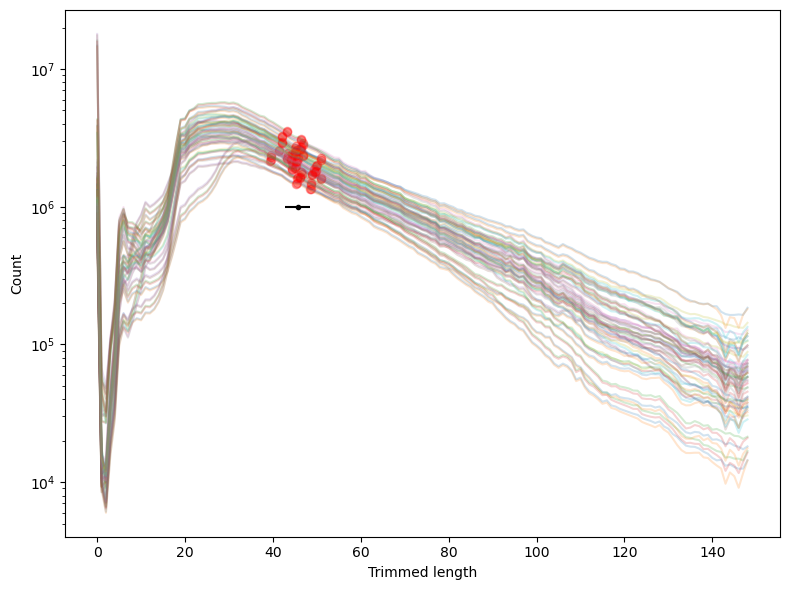

In [252]:
Samples=['18035FL-105-01_S1_L005','18035FL-105-01_S1_L006','18035FL-105-01V1-01_S1_L008','18035FL-105-02_S2_L005','18035FL-105-02_S2_L006','18035FL-105-01V1-02_S2_L008','18035FL-105-03_S3_L005','18035FL-105-03_S3_L006','18035FL-105-01V1-03_S3_L008','18035FL-105-04_S4_L005','18035FL-105-04_S4_L006','18035FL-105-01V1-04_S4_L008','18035FL-105-05_S5_L005','18035FL-105-05_S5_L006','18035FL-105-01V1-05_S5_L008','18035FL-105-06_S6_L005','18035FL-105-06_S6_L006','18035FL-105-01V1-06_S6_L008','18035FL-105-07_S7_L005','18035FL-105-07_S7_L006','18035FL-105-01V1-07_S7_L008','18035FL-105-08_S8_L005','18035FL-105-08_S8_L006','18035FL-105-01V1-08_S8_L008','18035FL-105-09_S9_L005','18035FL-105-09_S9_L006','18035FL-105-01V1-09_S9_L008','18035FL-105-10_S10_L005','18035FL-105-10_S10_L006','18035FL-105-01V1-10_S10_L008','18035FL-105-11_S11_L005','18035FL-105-11_S11_L006','18035FL-105-01V1-11_S11_L008','18035FL-105-12_S12_L005','18035FL-105-12_S12_L006','18035FL-105-01V1-12_S12_L008']

Samples = Samples
n_samples = len(Samples)
cols = 4
rows = 3#np.ceil(n_samples//cols).astype(int)

#fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))

fig, ax = plt.subplots(1,1, figsize=(8,6))
L = []
for sample in Samples:
    file = f'/scratch/jbreda/PROseq/resources/fastq_trimmed/{sample}_trimmed_report.txt'

    f_reads_with_adapter, df = read_report(file)

    # get average length of trimmed reads
    l = np.zeros([2,2])
    for r in df.keys():
        idx = df[r].loc[:,'trimmed length'] > 0
        l[r-1,0] = np.sum(df[r].loc[idx,"trimmed length"]* (df[r].loc[idx,"count"]/df[r].loc[idx,"count"].sum()))
        idx = np.argmin(np.abs(df[r].loc[:,"trimmed length"]-l[r-1,0]))
        l[r-1,1] = df[r].loc[idx,"count"]


    #f = int(sample.split('_')[1].replace('S',''))-1

    #ax = axes.flat[f]
    #time = f*4
    #ax.set_title(f't = {time}\nWith adapter : {f_reads_with_adapter[0]:.0f}, {f_reads_with_adapter[1]:.0f} %' )

    for r in df.keys():
        ax.plot(df[r].loc[:,'trimmed length'], df[r].loc[:,'count'], label=f'Read {r}', alpha=0.2)
        ax.plot(l[r-1,0], l[r-1,1],'or', alpha=0.3)

    L.append(l[0,0])
    L.append(l[1,0])

ax.set_xlabel('Trimmed length')
ax.set_ylabel('Count')

mu = np.mean(L)
std = np.std(L)
ax.errorbar(mu, 1e6, xerr=std, fmt='k.')

ax.set_yscale('log')

fig.tight_layout()

with open('tmp.txt', 'w') as f:
    f.write(str(int(np.round(mu))))
